Testing CNN method from https://wandb.ai/mostafaibrahim17/ml-articles/reports/An-Introduction-to-Audio-Classification-with-Keras--Vmlldzo0MDQzNDUy#:~:text=%EF%BB%BFKeras%20is%20a%20go,both%20beginners%20and%20advanced%20users.

https://keras.io/guides/sequential_model/

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers # example functions: Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
from keras import Input
import matplotlib.pyplot as plt
import time

In [24]:
def get_data(audio_path, meta_file, label_name, load_length):
    songs_matrix = []
    songs_label = []
    audio_list = os.listdir(audio_path)
    df = pd.read_csv(meta_file)
    min_width = 1000
    for name in audio_list:
        # parse out number part of the data files so we can get the corresponding label from meta_file
        number = name.replace('_', '.').split('.')[0]
        filepath = os.path.join(audio_path, name)
        # skipping files that are less than 250KB ~ 5sec long
        # this is to make sure we have enough length for sampling fft time intervals
        if os.path.getsize(filepath) < 250000:
            continue
        # ============ load the data and get matrix ============
        # replace this block with function that cleansup data and outputs a feature matrix per file
        # make sure that the size of the feature matrix is the same for all files
        # name the output feature matrix mfccs 
        song, sr = librosa.load(filepath, duration=load_length)
        mfccs = librosa.feature.mfcc(y = song, n_mfcc = 40)#, n_fft=512)
        if mfccs.shape[1] < min_width:
            print(number)
            min_width = np.minimum(mfccs.shape[1], min_width)
        #mfcc = np.mean(mfccs, axis=1) # average over columns, shape(n_mfcc, )
        # ======================================================
        songs_matrix.append(mfccs)
        songs_label.append(df[label_name].loc[df.cat_num == float(number)].item())
    return np.array(songs_matrix), np.array(songs_label)

In [67]:
# for converting strings of label from one division to another, e.g. fam/subfam to critter name
def convert_labels(labels, meta_file, from_division, to_division):
    # find label in labels in meta_file under column from_division
    # append as key in dictionary lookup_table
    # append as value the correspondign label in to_division

    df = pd.read_csv(meta_file, usecols=[from_division, to_divison])
    lookup_table = dict() # look up table for new label
    for label in labels:
        if label in lookup_table.keys():
            continue
        idx = df.loc[df[from_division]==label].index[0]
        lookup_table[label] = df[to_divison][idx]
    return [lookup_table[label] for label in labels]

# example testing block
# from_division = 'fam_or_subfam'
#to_division = 'critter_name'
##meta_file = 'MLNS_Insects_Fams_05212024.csv'
#labels = ['Acrididae', 'Cicadidae', 'Acrididae', 'Listroscelidinae', 
#                  'Mogoplistinae', 'Nemobiinae', 'Oecanthinae', 'Phalangopsidae',
#                  'Phaneropterinae', 'Oecanthinae', 'Tettigoniinae','Trigonidiinae']    
#convert_labels(labels, meta_file, from_division, to_division)

"from_division = 'fam_or_subfam'\nto_division = 'critter_name'\nmeta_file = 'MLNS_Insects_Fams_05212024.csv'\nlabels = ['Acrididae', 'Cicadidae', 'Acrididae', 'Listroscelidinae', \n                  'Mogoplistinae', 'Nemobiinae', 'Oecanthinae', 'Phalangopsidae',\n                  'Phaneropterinae', 'Oecanthinae', 'Tettigoniinae','Trigonidiinae']    \nconvert_labels(labels, meta_file, from_division, to_division)"

In [62]:
# load all audio in audio_path
# convert to matrix, save in np array, 
# load the corresponding label_name from lable_filename, save in another np array

audio_path = 'E:\chirpfiles\\no_voice_files'
meta_file = 'MLNS_Insects_Fams_05212024.csv'
label_name = 'fam_or_subfam'
start = time.time()
songs_matrix, songs_label = get_data(audio_path, meta_file, label_name, 5)
end = time.time()
print('time loading:', end - start)

103160
time loading: 114.94135451316833


In [64]:
songs_matrix.shape
print(np.unique(songs_label, return_counts=True))

(array(['Acrididae', 'Cicadidae', 'Conocephalinae', 'Eneopterinae',
       'Gryllinae', 'Gryllotalpidae', 'Hapithinae', 'Listroscelidinae',
       'Mogoplistinae', 'Nemobiinae', 'Oecanthinae', 'Phalangopsidae',
       'Phaneropterinae', 'Pseudophyllinae', 'Tettigoniinae',
       'Trigonidiinae'], dtype='<U16'), array([   1,   54,  761,   22, 1324,   39,  348,    9,  248,  317,  589,
         11,  474,  133,  199,  464], dtype=int64))


In [78]:
# check balanceness of whole dataset 
#print(np.unique(songs_label, return_counts=True))
delete_list = list(np.where(songs_label=='Acrididae')[0])+list(np.where(songs_label=='Listroscelidinae')[0])+list(np.where(songs_label=='Phalangopsidae')[0])

In [79]:
short_label = np.delete(songs_label, delete_list)
short_matrix = np.delete(songs_matrix, delete_list, 0)

In [80]:
print(np.unique(short_label, return_counts=True))

(array(['Cicadidae', 'Conocephalinae', 'Eneopterinae', 'Gryllinae',
       'Gryllotalpidae', 'Hapithinae', 'Mogoplistinae', 'Nemobiinae',
       'Oecanthinae', 'Phaneropterinae', 'Pseudophyllinae',
       'Tettigoniinae', 'Trigonidiinae'], dtype='<U16'), array([  54,  761,   22, 1324,   39,  348,  248,  317,  589,  474,  133,
        199,  464], dtype=int64))


In [81]:
# convert insec fam into numbers. use le.inverse_transform to go from number to name
le = LabelEncoder()
songs_label_num = le.fit_transform(short_label)
songs_label_onehot = to_categorical(songs_label_num) # why do we do this??
data_matrix = short_matrix
data_label = songs_label_onehot

In [112]:
#np.unique(songs_label, return_counts=True)
#print(songs_matrix.shape)
#sub_songs_matrix = songs_matrix[:, :, 0:600]

if ever need to convert onehot matrix back to string label
#label_num = np.sum(songs_label_onehot*np.arange(0,songs_label_onehot.shape[1]), axis=1)
#print(le.inverse_transform(label_num.astype(int)))

In [82]:
X_train, X_test, y_train, y_test = train_test_split(data_matrix, data_label, 
                                                    test_size = .2, random_state = 404)
## from bootcamp notes
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))

X_train.shape

(3977, 40, 216, 1)

In [83]:
#input_shape = (X_train.shape[1], 1) # n_featuer-by-1 vector
input_shape =  (X_train.shape[1], X_train.shape[2],1,)

model = Sequential() 
model.add(Input(input_shape))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=2))
#model.add(layers.Dropout(0.2))
#model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
#model.add(layers.MaxPooling2D((2,2), strides=2))
#model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(le.classes_), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

In [84]:
start = time.time()
epochs = 10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_test, y_test))
end = time.time()
print('fit time: ', end - start)
#predicted_vector = model.predict(X_test)
#predicted_class_index = np.argmax(predicted_vector, axis=-1)
#le.inverse_transform(predicted_class_index)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.1348 - loss: 116.0000 - val_accuracy: 0.0834 - val_loss: 2.5512
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.1321 - loss: 2.5433 - val_accuracy: 0.2583 - val_loss: 2.5240
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.2639 - loss: 2.5154 - val_accuracy: 0.2583 - val_loss: 2.4976
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.2622 - loss: 2.4878 - val_accuracy: 0.2583 - val_loss: 2.4729
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.2585 - loss: 2.4626 - val_accuracy: 0.2583 - val_loss: 2.4494
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.2669 - loss: 2.4396 - val_accuracy: 0.2583 - val_loss: 2.4275
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.2649 - loss: 2.4150 - val_accuracy: 0.2583 - val_loss: 2.4075
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.2596 - loss: 2.3990 - val_ac

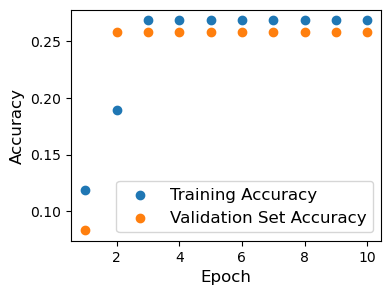

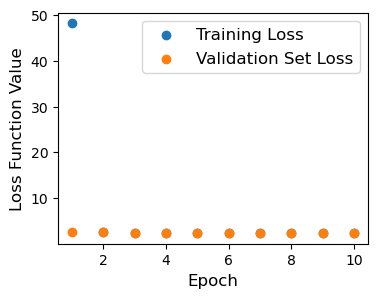

In [87]:
history_dict = history.history
plt.figure(figsize = (4, 3))
epochs = 10
plt.scatter(range(1,epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,epochs+1), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()


plt.figure(figsize = (4, 3))

plt.scatter(range(1,epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,epochs+1), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

In [57]:
predicted_vector = model.predict(X_test)
predicted_class_index = np.argmax(predicted_vector, axis=-1)
le.inverse_transform(predicted_class_index)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


array(['kaydid', 'cricket', 'kaydid', 'cricket', 'kaydid', 'cricket',
       'kaydid', 'cricket', 'cricket', 'kaydid', 'kaydid', 'cicada',
       'cricket', 'cricket', 'cricket', 'kaydid', 'cricket', 'cricket',
       'kaydid', 'cricket', 'kaydid', 'cricket', 'kaydid', 'cricket',
       'cricket', 'kaydid', 'kaydid', 'cricket', 'cricket', 'kaydid',
       'kaydid', 'cricket', 'cricket', 'cricket', 'cricket', 'kaydid',
       'cricket', 'kaydid', 'cricket', 'cricket', 'cricket', 'kaydid',
       'kaydid', 'cricket', 'kaydid', 'kaydid', 'kaydid', 'kaydid',
       'kaydid', 'cricket', 'kaydid', 'kaydid', 'cricket', 'cricket',
       'cricket', 'kaydid', 'cricket', 'kaydid', 'cricket', 'kaydid',
       'cricket', 'cricket', 'cricket', 'kaydid', 'cricket', 'cricket',
       'kaydid', 'kaydid', 'cricket', 'kaydid', 'cricket', 'kaydid',
       'kaydid', 'cricket', 'cricket', 'cricket', 'kaydid', 'cricket',
       'kaydid', 'cricket', 'cricket', 'cricket', 'kaydid', 'cricket',
       'kaydid',

Does training repeatedly increase performance??
What does Epoch and batch size do?

using conv2d(64), maxpool, flatten, dense, dense, batch size 32
Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 552ms/step - accuracy: 0.9391 - loss: 6.2835 - val_accuracy: 0.8545 - val_loss: 11.0454
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 549ms/step - accuracy: 0.9566 - loss: 8.4944 - val_accuracy: 0.8216 - val_loss: 11.1535
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 560ms/step - accuracy: 0.8765 - loss: 8.8313 - val_accuracy: 0.7230 - val_loss: 23.5377
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 565ms/step - accuracy: 0.9043 - loss: 6.7910 - val_accuracy: 0.8075 - val_loss: 14.2637
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 580ms/step - accuracy: 0.9250 - loss: 6.7538 - val_accuracy: 0.7653 - val_loss: 15.3153
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 559ms/step - accuracy: 0.9108 - loss: 6.5910 - val_accuracy: 0.8920 - val_loss: 6.9638
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 551ms/step - accuracy: 0.9831 - loss: 1.6024 - val_accuracy: 0.8310 - val_loss: 12.2536
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 562ms/step - accuracy: 0.9745 - loss: 1.0641 - val_accuracy: 0.8498 - val_loss: 11.0394
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 551ms/step - accuracy: 0.9707 - loss: 0.9651 - val_accuracy: 0.8216 - val_loss: 14.1250
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 557ms/step - accuracy: 0.9534 - loss: 1.5526 - val_accuracy: 0.8451 - val_loss: 7.3341
fit time:  151.07773733139038

In [58]:
y_test = y_test.astype(int) 
y_test_cate = list(y_test[:,1] + 2*y_test[:,2]) 
#y_test_names = le.inverse_transform(y_test[:,1] + 2*y_test[:,2]+3*y_test[:,3])
#print(y_test_names)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_cate, predicted_class_index)
pd.DataFrame(conf_mat)#,
#                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
#                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])

,0,1,2
0,2,6,3
1,0,562,76
2,0,63,287


0.27526132404181186